In [6]:
import tifffile
import numpy as np
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.morphology import medial_axis, skeletonize, thin
import torch

In [3]:
def normalize(img_np, new_min=0, new_max=65535, invert=False):
    img_min = np.min(img_np)
    img_max = np.max(img_np)

    img_normd = (img_np - img_min) * ((new_max - new_min) / (img_max - img_min)) + new_min

    if invert:
        img_normd = new_max - img_normd

    return img_normd

def condition(img):
    img_copy = np.copy(img)
    img_copy[img_copy < 11000] = 0
    img_copy[img_copy >= 11000] = 1
    return img_copy

# 根据range提波峰不一定对，要自适应
def cal_FWHM(img, coor, range_):
    def cal_FWHM_(img_list):
        half_max = max(img_list) / 2
        above_half_max = np.where(img_list >= half_max)[0]
        fwhm = above_half_max[-1] - above_half_max[0]
        return fwhm
    aniso_dimension = 2
    iso_dimension0 = 0
    iso_dimension1 = 1
    # calculate lateral FWHM (high resolution)
    
    coor0_floor = coor[0]-range_
    coor0_upper = coor[0]+range_
    coor1_floor = coor[1]-range_
    coor1_upper = coor[1]+range_
    coor2_floor = coor[2]-range_
    coor2_upper = coor[2]+range_
    
    iso_list0 = img[coor[0], coor1_floor:coor1_upper, coor[2]]
    iso_list1 = img[coor0_floor:coor0_upper, coor[1], coor[2]]
    # calculate axial FWHM (low resolution)
    aniso_list = img[coor[0], coor[1], coor2_floor:coor2_upper]
    # print("aniso_list: ", cal_FWHM_(aniso_list))
    return cal_FWHM_(iso_list0), cal_FWHM_(iso_list1), cal_FWHM_(aniso_list)

def get_var_name(var):
    return [name for name in globals() if globals()[name] is var][0]



In [7]:
GT_img = tifffile.imread('./dataset/img_simulation/GT0064.tif') # [0:32, 0:32, 0:32]
# deformed_img = norm(tifffile.imread('../aniso2345/deformed_0453.tif'), 0, 65535).astype(np.uint16)# [0:32, 0:32, 0:32]
aniso4_img = tifffile.imread('./dataset/img_simulation/input0064.tif') # [0:32, 0:32, 0:32]
selfnet_img = tifffile.imread('./dataset/img_simulation/selfnet0064.tif') # [0:32, 0:32, 0:32]
MPCN_img = tifffile.imread('./dataset/img_simulation/MPCN0064.tif') # [0:32, 0:32, 0:32]

GT_img = normalize(GT_img).astype(np.uint16)
aniso4_img = normalize(aniso4_img).astype(np.uint16)
selfnet_img = normalize(selfnet_img).astype(np.uint16)
MPCN_img = normalize(MPCN_img).astype(np.uint16)

In [1]:
GT_img = tifffile.imread('./dataset/img_simulation/GT0064.tif') # [0:32, 0:32, 0:32]
# deformed_img = norm(tifffile.imread('../aniso2345/deformed_0453.tif'), 0, 65535).astype(np.uint16)# [0:32, 0:32, 0:32]
aniso4_img = tifffile.imread('./dataset/img_simulation/input0064.tif') # [0:32, 0:32, 0:32]
selfnet_img = tifffile.imread('./dataset/img_simulation/selfnet0064.tif') # [0:32, 0:32, 0:32]
MPCN_img = tifffile.imread('./dataset/img_simulation/MPCN0064.tif') # [0:32, 0:32, 0:32]

GT_img = normalize(GT_img).astype(np.uint16)
aniso4_img = normalize(aniso4_img).astype(np.uint16)
selfnet_img = normalize(selfnet_img).astype(np.uint16)
MPCN_img = normalize(MPCN_img).astype(np.uint16)

ske_img = skeletonize(condition(GT_img))
tifffile.imwrite('./dataset/img_simulation/ske0064.tif', ske_img)

cut_size = 16
threshold = 10000

def print_FWHM(img, GT_img):
    ske_img = skeletonize(condition(GT_img)) * GT_img

    iso_list0 = []
    iso_list1 = []
    aniso_list = []
    for i in range(cut_size, GT_img.shape[0]-cut_size, 1):
        for j in range(cut_size, GT_img.shape[1]-cut_size, 1):
            for k in range(cut_size, GT_img.shape[2]-cut_size, 1):
                if ske_img[i,j,k] > threshold:
                    iso_val0, iso_val1, aniso_val = cal_FWHM(img, [i,j,k], 10)
                    iso_list0.append(iso_val0)
                    iso_list1.append(iso_val1)
                    aniso_list.append(aniso_val)
    
    # print(get_var_name(img), 'iso_list0', sum(iso_list0) / len(iso_list0))
    # print(get_var_name(img), 'iso_list1', sum(iso_list1) / len(iso_list1))
    # print(get_var_name(img), 'aniso_list', sum(aniso_list) / len(aniso_list))

    print(get_var_name(img), 'iso_ratio', (sum(aniso_list) / sum(iso_list0) + sum(aniso_list) / sum(iso_list1))/2)
    

print_FWHM(GT_img, GT_img)
print_FWHM(aniso4_img, GT_img)
print_FWHM(selfnet_img, GT_img)
print_FWHM(MPCN_img, GT_img)

NameError: name 'tifffile' is not defined

aniso4_img iso_list0 2.0
aniso4_img aniso_list 9.0
aniso4_img iso_ratio 4.5


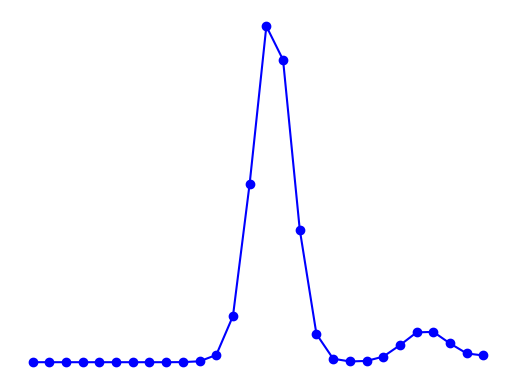

In [63]:
GT_img = tifffile.imread('./dataset/img_simulation/GT0064.tif') # [0:32, 0:32, 0:32]
# deformed_img = norm(tifffile.imread('../aniso2345/deformed_0453.tif'), 0, 65535).astype(np.uint16)# [0:32, 0:32, 0:32]
aniso4_img = tifffile.imread('./dataset/img_simulation/input0064.tif') # [0:32, 0:32, 0:32]
selfnet_img = tifffile.imread('./dataset/img_simulation/selfnet0064.tif') # [0:32, 0:32, 0:32]
MPCN_img = tifffile.imread('./dataset/img_simulation/MPCN0064.tif') # [0:32, 0:32, 0:32]

GT_img = normalize(GT_img).astype(np.uint16)
aniso4_img = normalize(aniso4_img).astype(np.uint16)
selfnet_img = normalize(selfnet_img).astype(np.uint16)
MPCN_img = normalize(MPCN_img).astype(np.uint16)

ske_img = skeletonize(condition(GT_img))
tifffile.imwrite('./dataset/img_simulation/ske0064.tif', ske_img)
ske_img = np.zeros_like(ske_img)
ske_img[61,26,64] = 65535
tifffile.imwrite('./dataset/img_simulation/ske0064_test.tif', ske_img)

cut_size = 16
threshold = 10000

def cal_FWHM(img, coor, range_):
    def cal_FWHM_(img_list):
        mid_index = len(img_list) // 2
        for i in range(mid_index, -1, -1):
            if img_list[i]<threshold:
                left_index = i
                break
        for i in range(mid_index, len(img_list)-1, 1):
            if img_list[i]<threshold:
                right_index = i
                break
        
        if 'left_index' not in locals() and 'left_index' not in globals():
            return None        
        if 'right_index' not in locals() and 'right_index' not in globals():
            return None
        
        front_ground_list = img_list[left_index:right_index+1]
        
        half_max = max(front_ground_list) / 2
        above_half_max = np.where(front_ground_list >= half_max)[0]
        fwhm = above_half_max[-1] - above_half_max[0]
        return fwhm
    
    coor0_floor = coor[0]-range_
    coor0_upper = coor[0]+range_
    coor1_floor = coor[1]-range_
    coor1_upper = coor[1]+range_
    coor2_floor = coor[2]-range_
    coor2_upper = coor[2]+range_
    
    iso_list0 = img[coor[0], coor1_floor:coor1_upper, coor[2]]
    aniso_list = img[coor[0], coor[1], coor2_floor:coor2_upper]
    
    plt.plot(iso_list0, marker='o', linestyle='-', color='blue')
    plt.plot(aniso_list, marker='o', linestyle='-', color='orange')
    
    plt.axis('off')
    
    return cal_FWHM_(iso_list0), cal_FWHM_(aniso_list)

def print_FWHM(img, GT_img):
    ske_img = skeletonize(condition(GT_img)) * GT_img

    iso_list0 = []
    aniso_list = []
    

    if ske_img[61,26,64] > threshold:
        iso_val0, aniso_val = cal_FWHM(img, [61,26,64], 14)
        iso_list0.append(iso_val0)
        aniso_list.append(aniso_val)

    print(get_var_name(img), 'iso_list0', sum(iso_list0) / len(iso_list0))
    print(get_var_name(img), 'aniso_list', sum(aniso_list) / len(aniso_list))
    
    print(get_var_name(img), 'iso_ratio', (sum(aniso_list) / sum(iso_list0)))
    return 
    
print_FWHM(aniso4_img, GT_img)

In [ ]:
print_FWHM(GT_img, GT_img)
print_FWHM(aniso4_img, GT_img)
print_FWHM(selfnet_img, GT_img)
print_FWHM(MPCN_img, GT_img)

2024/6/29 poster 画图

In [10]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from scipy.optimize import curve_fit

In [6]:
img_ori = tifffile.imread('/share/home/wangwb/workspace/sr_3dunet/datasets/bigbigtif_sr/img_MIP_input.tif')
img_sr = tifffile.imread('/share/home/wangwb/workspace/sr_3dunet/datasets/bigbigtif_sr/img_MIP_output.tif')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


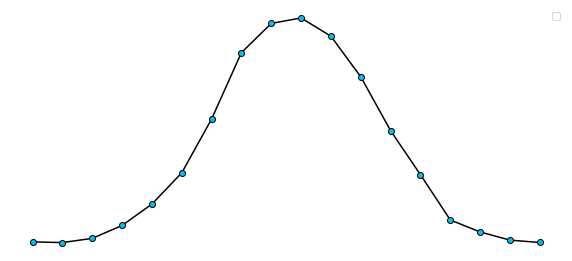

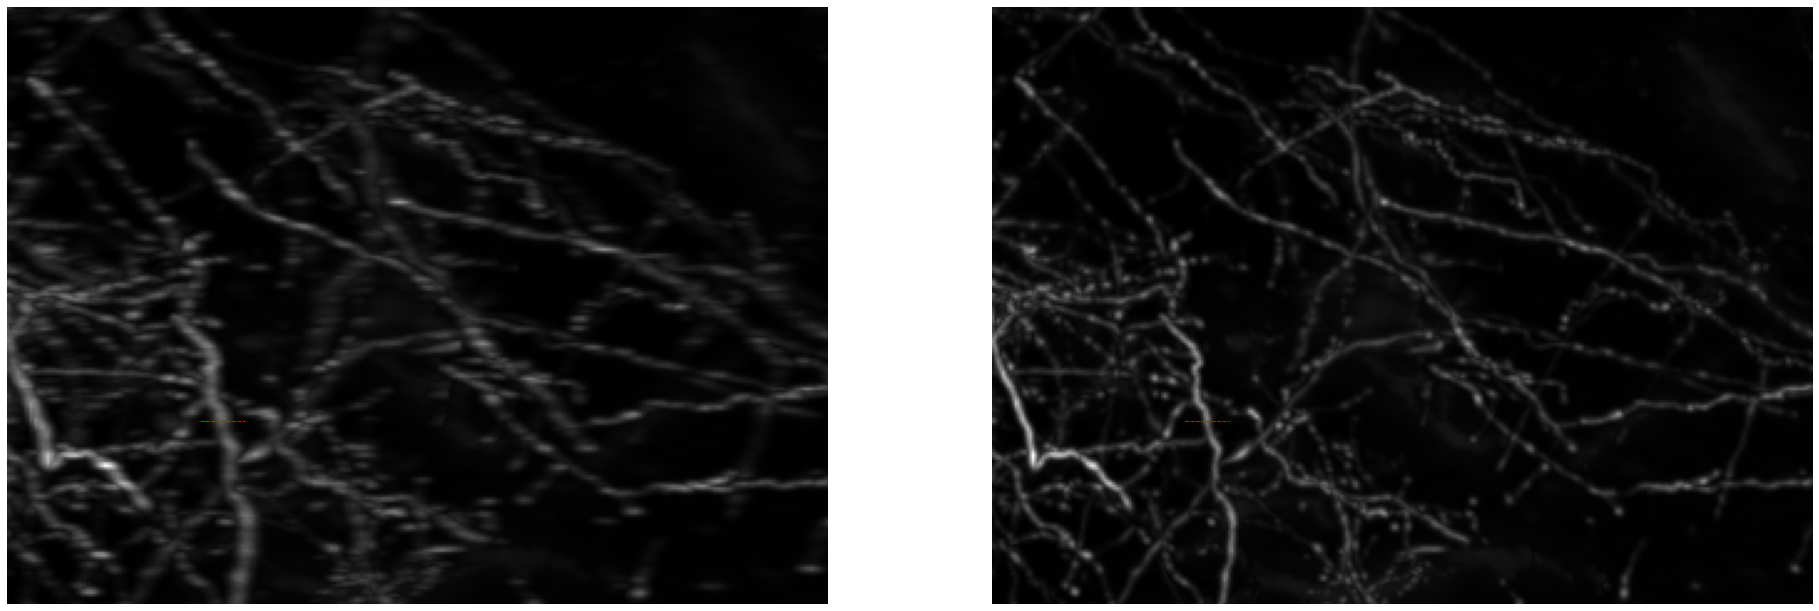

In [56]:
# Increase y
start_x = 77
start_y = 166 # 110

# size = 64
len_ = 18

def norm_list(input_list):
    output_list = (input_list - np.min(input_list)) / (np.max(input_list) - np.min(input_list))
    return output_list

def gaussian_fit(list_coor, list_val):

    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    def getmean_and_sigma(list_coor, list_val):
        x = np.asarray(range(len(list_coor)))
        y = list_val
        mean = sum(x * y)
        sigma = sum(y*(x-mean)**2)/len(list_coor)
        return mean,sigma
    
    list_val = norm_list(list_val)
    mean, sigma = getmean_and_sigma(list_coor, list_val)
    popt, pcov = curve_fit(gaus, list_coor,list_val,p0=[1, mean, sigma])
    list_val = gaus(list_coor,*popt)
    list_val = norm_list(list_val)
    return list_coor, list_val

def get_listxy(img):
    list_coor = list(range(0,len_))
    list_val = img[start_y, start_x:start_x+len_]
    return list_coor, list_val

def plt_img():
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    
    list_x, list_y_input = get_listxy(img_ori)
    list_y_input = norm_list(list_y_input)
    # list_x, list_y_input = gaussian_fit(list_x, list_y_input)
    # plt.plot(list_x, list_y_input, color='red', label='input_img_iso')
    plt.plot(list_y_input, marker='o', linestyle='-', color='black', markerfacecolor='#00BFFF')
    
    list_x, list_y_input = get_listxy(img_sr)
    list_y_input = norm_list(list_y_input)
    # plt.plot(list_x, list_y_input, color='green', label='GT_img_iso')
    
    # plt.plot(list_y_input, marker='o', linestyle='-', color='black')
    # markerfacecolor='cyan', 00BFFF 0000CC
    # plt.plot(list_y_input, marker='o', linestyle='-', color='black', markerfacecolor='#00BFFF')
    plt.axis('off')

    plt.legend()
    plt.xlabel("Distance(μm)")
    plt.ylabel("Normalized intensity")
    plt.show()
    
    plt.figure(figsize=(50, 30))
    plt.subplot(234)
    plt.imshow(img_ori, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    # plt.title('input_img_anisoMIP')
    
    plt.subplot(235)
    plt.imshow(img_sr, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    # plt.title('input_img_anisoMIP')
    
plt_img()